# Week 4 - Exploring Semantic Spaces (Word Embeddings)
This week, we build on last week's topic modeling techniques by taking a text corpus we have developed, specifying an underlying number of dimensions, and training a model with a neural network auto-encoder (one of Google's word2vec  algorithms) that best describes corpus words in their local linguistic contexts, and exploring their locations in the resulting space to learn about the discursive culture that produced them.

This is our third document representation we have learned: First, we used word counts. Second, we used LDA topic models built around term coocurrence in the same document (i.e., a "bag of words"). Third, documents here are represented as densely indexed locations in dimensions, so that distances between those documents (and words) contain more information, though they require the full vector of dimension loadings (rather than just a few selected topic loadings) to describe. We will explore these spaces to understand complex, semantic relationships between words, index documents with descriptive words, identify the likelihood that a given document would have been produced by a given vector model, and explore how semantic categories can help us understand the cultures that produced them.

Note that most modern natural language processing (NLP) research, at least in computer science, uses word embeddings. This is the foundation of most state-of-the-art models.

Also note that the code in this Notebook can take many minutes or even hours to run. This is the case for most NLP research these days, and it's a good opportunity to start thinking about how to manage high-compute workloads, such as running code on small samples to test it, loading datafiles in [chunks](https://stackoverflow.com/a/25962187), or [multiprocessing](https://en.wikipedia.org/wiki/Multiprocessing).

## <font color="red">*Pitch Your Project*</font>

<font color="red">In the three cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words), **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words), and **HOW** you plan to investigate it (i.e., what are the approaches and operations you plan to perform, in sequence, to yield this insight) (<400 words).

# ***What?*** 
<200 words

## ***Why?***
<200 words

## ***How?***
<400 words

## <font color="red">*Pitch Your Sample*</font>

<font color="red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors you about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication) beyond this class? (<300 words).

## ***Which (words)?***
<300 words

In [6]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

import numpy as np #For arrays
import pandas as pd #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

In [5]:
pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

  Cloning git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /tmp/pip-req-build-v16c5fhp
  Running command git clone -q git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /tmp/pip-req-build-v16c5fhp


In [ ]:
!git clone https://github.com/isaduan/hearings-2005-2010 /root/hearings

Cloning into '/root/hearings'...
remote: Enumerating objects: 275, done.
remote: Counting objects: 100% (275/275), done.
remote: Compressing objects: 100% (275/275), done.
remote: Total 275 (delta 2), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (275/275), 29.44 MiB | 4.45 MiB/s, done.
Resolving deltas: 100% (2/2), done.


## <font color="red">*Exercise 1*</font>

<font color="red">Construct cells immediately below this that embed documents related to your final project using at least two different specification of `word2vec` and/or `fasttext`, and visualize them each with two separate visualization layout specifications (e.g., TSNE, PCA). Then interrogate critical word vectors within your corpus in terms of the most similar words, analogies, and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the semantic organization of words in your corpora? Which estimation and visualization specification generate the most insight and appear the most robustly supported and why? 

<font color="red">***Stretch***: Explore different vector calculations beyond addition and subtraction, such as multiplication, division or some other function. What does this exploration reveal about the semantic structure of your corpus?

In [4]:
def get_records(folder):
    """
    Take a path of a folder where records are stored, load
    records into a dictionary that maps record ID to to texts
    
    Input: 
      folder: a string represents the folder name and path
    
    Return a dictionarythat maps record ID to to texts.     
    """
    texts_raw = {}
    for file in os.listdir(folder + "/"):
        print(file)
        if not file.endswith('.json') and not file.endswith('.git') :
            with open(file, 'r') as f:
                # read a file into a big string
                try:
                    texts_raw[file] = f.read()
                except:
                    continue
    
    return texts_raw 

In [ ]:
folder_0510 = "/root/hearings"
raw_0510 = get_records(folder_0510)

In [9]:
cd /root/hearings/

/root/hearings


In [11]:
len(raw_0510)

268

In [12]:
import json
with open('hearings-2005-2010.json', 'r') as f: 
    filesLst = json.loads(f.read())

In [13]:
import pandas

In [14]:
# convert data into a Data frame, add titles
k_lst = []
for k in raw_0510.keys():
    for result in filesLst['resultSet']:
        if result['granuleId'] == k:
            k_lst.append(result['title'])
v_lst = [v for v in raw_0510.values()]
i_lst = [k for k in raw_0510.keys()]
DF0510 = pandas.DataFrame({'index': i_lst, 'title': k_lst, 'raw_text': v_lst})

In [15]:
DF0510

,index,title,raw_text
0,CHRG-110shrg41101,Oversight of the Investigation of the Nasa Ins...,S. HRG. 110–434 \nSERIAL 110–37 \n\nOVERSIGH...
1,CHRG-110shrg34743,Promoting Travel to America: An Examination of...,PROMOTING \n\nTRAVEL \n\nAN\nEXAMINATION OF ...
2,CHRG-110shrg80088,Oversight of the Corporate Average Fuel Econom...,OVERSIGHT OF THE CORPORATE AVERAGE FUEL \...
3,CHRG-110hhrg35999,A Path Toward the Broader Use of Biofuels: Enh...,A PATH TOWARD THE BROADER USE OF\n\nBIOF...
4,CHRG-110shrg39014,Transportation Worker Identification Credentia...,TRANSPORTATION WORKER IDENTIFICATION \n\nCRE...
...,...,...,...
263,CHRG-109shrg63243,Reauthorization of the Coastal Zone Management...,REAUTHORIZATION OF THE \n\nCOASTAL ZONE MA...
264,CHRG-109shrg26532,"Nominations of David A. Sampson, to Be Deputy ...",S. HRG. 109–336\n\nNOMINATIONS OF DAVID A...
265,CHRG-110hhrg33105,Amending Executive Order 12866: Good Governanc...,AMENDING EXECUTIVE ORDER 12866:\nGOOD GOVE...
266,CHRG-109shrg25323,Human Spaceflight: the Space Shuttle and Beyond,HUMAN SPACEFLIGHT: THE SPACE SHUTTLE AND ...


In [ ]:
# wrong practice! get a matrix of characters, instead of words :(
DF0510['tokenized_text'] = DF0510['raw_text'].apply(lambda x: lucem_illud.word_tokenize(x, MAX_LEN=1800000))

In [ ]:
DF0510['normalized_tokens'] = DF0510['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, MAX_LEN=1800000))

In [ ]:
# right way!
DF0510['tokenized_sents'] = DF0510['raw_text'].apply(lambda x: [lucem_illud.word_tokenize(s, MAX_LEN=2000000) for s in lucem_illud.sent_tokenize(x)])


In [ ]:
DF0510['normalized_sents'] = DF0510['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])


In [ ]:
save = DF0510[['index', 'title','normalized_sents']]

In [ ]:
save.to_csv('DF0510.csv')

## use skipgram

In [ ]:
W2V = gensim.models.word2vec.Word2Vec(DF0510['normalized_sents'].sum(), sg=1, workers=3, compute_loss=True)

In [ ]:
W2V.save("W2V_SG")

In [ ]:
W2V.wv.index2word 
# look up words; interesting ones (research, U.S., NASA, Chairman, 
# industry, technology, american, safety, important, science, energy, work, psn, 
# national, fund, $, public, change, federal, dr, mr, consumer, space, fuel, risk, climate,
# business, university, price, future )

In [ ]:
# most similar words to us includes Chinese (No. 3)
# suggesting how self identity relates to a foreign 'other'
W2V.most_similar('u.s', topn=20) 

[('unite', 0.6192792654037476),
 ('rean', 0.6138784885406494),
 ('chinese', 0.5981453061103821),
 ('nation', 0.5952105522155762),
 ('ministry', 0.5922368168830872),
 ('http://bookstore.gpo.gov', 0.571690022945404),
 ('state', 0.5713860988616943),
 ('u.s.-', 0.5673544406890869),
 ('mestic', 0.5637867450714111),
 ('nadian', 0.5624779462814331),
 ('private-', 0.5595884323120117),
 ('amcham', 0.5571780800819397),
 ('deere', 0.5542914867401123),
 ('telework', 0.5522271394729614),
 ('korean', 0.5520291328430176),
 ('country', 0.5517922639846802),
 ('a`-vis', 0.5504310131072998),
 ('arbiter', 0.5496490001678467),
 ('ko-', 0.547967791557312),
 ('foreign', 0.5450271368026733)]

In [ ]:
W2V.most_similar('technology', topn=20) 

[('tech-', 0.8245952129364014),
 ('nology', 0.8244220614433289),
 ('nologies', 0.7658206224441528),
 ('technological', 0.6767820119857788),
 ('atds', 0.6335196495056152),
 ('revo-', 0.6321967840194702),
 ('cializing', 0.6290611624717712),
 ('nanotech-', 0.6287561058998108),
 ('celerate', 0.6285820007324219),
 ('innovation', 0.6249045729637146),
 ('diffusion', 0.6146519184112549),
 ('formational', 0.6131174564361572),
 ('quantum', 0.6124416589736938),
 ('transformational', 0.6084312796592712),
 ('inno-', 0.6071422100067139),
 ('microelectronic', 0.6053298711776733),
 ('warfighter', 0.6025417447090149),
 ('vative', 0.5964927077293396),
 ('troduction', 0.5944600701332092),
 ('nanosciences', 0.5942760705947876)]

In [ ]:
# not surprisingly, technology is more applied, 
# science is more theoretical, as we see math, astronomy, anthropology
W2V.most_similar('science', topn=20) 

[('mathe-', 0.6735905408859253),
 ('mathematics', 0.6644326448440552),
 ('ematics', 0.6603355407714844),
 ('math-', 0.6484788656234741),
 ('matics', 0.6431640386581421),
 ('scientific', 0.6400326490402222),
 ('jsost', 0.6269738078117371),
 ('nctm', 0.6218098402023315),
 ('astronomy', 0.6192607879638672),
 ('anthropology', 0.6156793832778931),
 ('grees', 0.6137228012084961),
 ('nit', 0.6087647676467896),
 ('foren-', 0.6073204278945923),
 ('astron-', 0.606158971786499),
 ('annals', 0.605897068977356),
 ('math', 0.6023211479187012),
 ('usgeo', 0.5991204380989075),
 ('2000–2005', 0.5985238552093506),
 ('nsf', 0.5977862477302551),
 ('astrophysics', 0.5976592302322388)]

In [ ]:
# Find which word least matches the others within a word set 
W2V.doesnt_match(['u.s.', 'china', 'japan', 'u.k.', 'korea'])

'korea'

In [ ]:
# consumer to safety is industry to ?
# less interpretable results though
W2V.most_similar(positive=['consumer', 'industry'], negative = ['safety'])

[('compa-', 0.58393394947052),
 ('sumers', 0.5686607360839844),
 ('company', 0.5638266801834106),
 ('sumer', 0.5399460196495056),
 ('prepay', 0.5389575958251953),
 ('retailer', 0.5342283248901367),
 ('customer', 0.5320632457733154),
 ('firm', 0.5191407203674316),
 ('marketplace', 0.5160177946090698),
 ('broke', 0.513572096824646)]

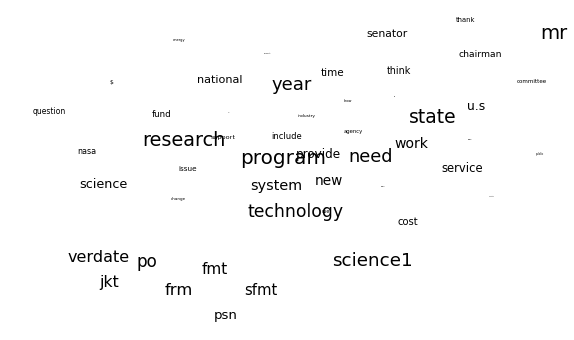

In [ ]:
# viusalization

numWords = 50
targetWords = W2V.wv.index2word[:numWords]

wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(W2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

### use CBOW

In [ ]:
W2V_CB = gensim.models.word2vec.Word2Vec(DF0510['normalized_sents'].sum(), sg=0, workers=3, compute_loss=True)

In [ ]:
W2V_CB.save("W2V_CB")

In [ ]:
# load model
W2V_CB = gensim.models.word2vec.Word2Vec.load("W2V_CB")

In [ ]:
W2V_CB.most_similar('u.s', topn=20) # CBOW generates more interpretable results

[('domestic', 0.6909058094024658),
 ('nation', 0.6142244338989258),
 ('foreign', 0.5791924595832825),
 ('worldwide', 0.5620349049568176),
 ('chinese', 0.5605299472808838),
 ('export', 0.550199568271637),
 ('country', 0.5484606027603149),
 ('unite', 0.5121808052062988),
 ('international', 0.49570906162261963),
 ('globally', 0.4930095970630646),
 ('mestic', 0.4915623664855957),
 ('import', 0.48808735609054565),
 ('canadian', 0.48777851462364197),
 ('overseas', 0.4842901825904846),
 ('europe', 0.48405519127845764),
 ('civilian', 0.48030316829681396),
 ('european', 0.4708408713340759),
 ('u.s.-based', 0.46065303683280945),
 ('canada', 0.45359569787979126),
 ('china', 0.44910702109336853)]

In [ ]:
# what U.S is not ... not silly, not crazy, not glad, not okey ..?
W2V_CB.most_similar(negative=['u.s'], topn=20)

[('okay', 0.508283257484436),
 ('apologize', 0.4646484851837158),
 ('suffice', 0.4604640603065491),
 ('preface', 0.45183372497558594),
 ('microphone', 0.4502241015434265),
 ('boss', 0.4499533176422119),
 ('glad', 0.4470151960849762),
 ('5-minute', 0.44228512048721313),
 ('mony', 0.4381866455078125),
 ('tes-', 0.43438178300857544),
 ('writ-', 0.4317936897277832),
 ('morrell', 0.4296662211418152),
 ('o’rourke', 0.4274439811706543),
 ('mike', 0.42714911699295044),
 ('testi-', 0.4243963956832886),
 ('mrs', 0.4243015646934509),
 ('crazy', 0.4237981140613556),
 ('liguori', 0.41902679204940796),
 ('knorr', 0.4189486503601074),
 ('silly', 0.41698068380355835)]

In [ ]:
W2V_CB.wv.similarity('u.s', 'innovation')

0.23127756

In [ ]:
W2V_CB.wv.similarity('china', 'innovation')

0.22262096

In [ ]:
positive_words = ['excellent', 'good', 'wonderful', 'perfect', 'innovative',
'new', 'newly','modern', 'mature', 'revolutionary']

In [ ]:
def compare_sentiments(str1, str2, word_lst):
  N = len(word_lst)
  s1 = []
  s2 = []
  for w in word_lst:
    s1.append(W2V_CB.wv.similarity(str1, w))
    s2.append(W2V_CB.wv.similarity(str2, w))
  return sum(s1) / N, sum(s2) / N

In [ ]:
# to my surprise, China are constrcuted in more positive light
# on the positive/negative spectrum
compare_sentiments('u.s', 'china', positive_words)

(0.10959897571010516, 0.16009166464209557)

In [ ]:
# in this way, we could systematically study the construction
# of foreign others
compare_sentiments('korean', 'japan', positive_words)

(0.024664485675748436, 0.08548546303063631)

In [ ]:
# and construction of technology
compare_sentiments('nanotechnology', 'computer', positive_words)

(0.20886589149013163, 0.14194580167531967)

In [ ]:
# business is more positive than university
compare_sentiments('business', 'university', positive_words)

(0.15026749335229397, 0.08827286884188652)

In [ ]:
# expert is more positive than public
# however, this does not mean public are themselves negative: maybe they
# express negative opinions that concern the policymakers
compare_sentiments('expert', 'public', positive_words)

(0.10937819611281156, 0.09109314274974167)

In [ ]:
# technology is more positive than science
compare_sentiments('science', 'technology', positive_words)

(0.15629732199013233, 0.22079180777072907)

In [ ]:
compare_sentiments('energy', 'fuel', positive_words)

(0.09670132026076317, 0.06062135873362422)

In [ ]:
compare_sentiments('risk', 'uncertainty', positive_words)

(0.09800056675449013, 0.06072517717257142)

In [ ]:
# I used good word list to construct positive words
W2V_CB.most_similar('good') # hard is good, easy is not!

[('bad', 0.6613117456436157),
 ('excellent', 0.5561313033103943),
 ('wonderful', 0.5378056764602661),
 ('perfect', 0.5216777920722961),
 ('hard', 0.5039718151092529),
 ('well', 0.5017821788787842),
 ('lot', 0.49605897068977356),
 ('kind', 0.47733309864997864),
 ('actually', 0.47509196400642395),
 ('know', 0.4660789966583252)]

In [ ]:
W2V_CB.most_similar('nanotechnology', topn=20) 

[('innovation', 0.5846204161643982),
 ('nanotech', 0.5796200037002563),
 ('r&d', 0.5712600350379944),
 ('transformational', 0.5652338862419128),
 ('interdisciplinary', 0.5596525073051453),
 ('commercialization', 0.5520420074462891),
 ('nanoscience', 0.5504926443099976),
 ('inno-', 0.5414364337921143),
 ('research', 0.5380749702453613),
 ('forefront', 0.5376797914505005),
 ('advancement', 0.516294538974762),
 ('revolutionary', 0.5066006779670715),
 ('biofuel', 0.5034797787666321),
 ('nurture', 0.5034692287445068),
 ('technological', 0.5020192265510559),
 ('biomedical', 0.4974139332771301),
 ('tiative', 0.49638110399246216),
 ('nanoelectronics', 0.4961091876029968),
 ('ehs', 0.49557599425315857),
 ('breakthrough', 0.48890072107315063)]

In [ ]:
W2V_CB.most_similar('computer', topn=20) 

[('software', 0.673740804195404),
 ('server', 0.6443838477134705),
 ('laptop', 0.6424560546875),
 ('machine', 0.6150432825088501),
 ('browser', 0.6138842105865479),
 ('desktop', 0.6056808829307556),
 ('ware', 0.600471019744873),
 ('portal', 0.5683589577674866),
 ('camera', 0.5670856237411499),
 ('pcs', 0.5554730296134949),
 ('archive', 0.5526312589645386),
 ('device', 0.549025297164917),
 ('soft-', 0.5484026670455933),
 ('computational', 0.5445111989974976),
 ('hacker', 0.5411697030067444),
 ('image', 0.5384922027587891),
 ('optical', 0.5330401659011841),
 ('password', 0.5316563248634338),
 ('visualization', 0.528083324432373),
 ('portable', 0.5199143886566162)]

In [ ]:
W2V_CB.most_similar('science', topn=20) 

[('scientific', 0.6391366720199585),
 ('stem', 0.5839155912399292),
 ('neering', 0.5760152339935303),
 ('research', 0.5589140057563782),
 ('astronomy', 0.5471537113189697),
 ('s&t', 0.5118564963340759),
 ('scientist', 0.5114455223083496),
 ('aeronautics', 0.5094804763793945),
 ('interdisciplinary', 0.500746488571167),
 ('physic', 0.4932098984718323),
 ('k–12', 0.4925425946712494),
 ('nautics', 0.488220751285553),
 ('mathematics', 0.4826509356498718),
 ('sci-', 0.48114147782325745),
 ('astrophysics', 0.477935254573822),
 ('aeronautical', 0.46699047088623047),
 ('nsf', 0.4639970362186432),
 ('simcalc', 0.45383864641189575),
 ('psychology', 0.444893479347229),
 ('sth', 0.4435671269893646)]

In [ ]:
W2V_CB.most_similar('new', topn=20) # commercialize is close to new

[('innovative', 0.581523060798645),
 ('newly', 0.5255005359649658),
 ('mature', 0.5001044869422913),
 ('modern', 0.4812227785587311),
 ('additional', 0.47713983058929443),
 ('revolutionary', 0.47687703371047974),
 ('commercialize', 0.4739138185977936),
 ('advance', 0.4719945788383484),
 ('exist', 0.4678264856338501),
 ('accelerate', 0.4651390016078949),
 ('emerge', 0.46503597497940063),
 ('enable', 0.45653754472732544),
 ('novel', 0.45158231258392334),
 ('traditional', 0.44923433661460876),
 ('cre-', 0.44560351967811584),
 ('simultaneously', 0.4427673816680908),
 ('similar', 0.44027137756347656),
 ('unique', 0.4367051124572754),
 ('orient', 0.43202751874923706),
 ('oper-', 0.4316343665122986)]

In [ ]:
W2V_CB.most_similar('future', topn=20) 

[('fu-', 0.6957786083221436),
 ('continue', 0.5302454829216003),
 ('current', 0.5184684991836548),
 ('sustain', 0.5094829201698303),
 ('ture', 0.5076127052307129),
 ('prospect', 0.4945690929889679),
 ('generation', 0.4944969415664673),
 ('transformation', 0.49009716510772705),
 ('nation', 0.48915064334869385),
 ('robust', 0.4866470694541931),
 ('historic', 0.48598918318748474),
 ('viability', 0.4838303029537201),
 ('term', 0.4815361201763153),
 ('potential', 0.4802461862564087),
 ('likely', 0.4783031940460205),
 ('particularly', 0.47565266489982605),
 ('jeopardize', 0.47397780418395996),
 ('crucial', 0.4724995493888855),
 ('reality', 0.4688153862953186),
 ('mitigate', 0.4665362238883972)]

In [ ]:
# is the result different for two models? No!
# Find which word least matches the others within a word set 
W2V_CB.doesnt_match(['u.s.', 'china', 'japan', 'u.k.', 'korea'])

'korea'

In [ ]:
# consumer to safety is industry to ?
# less interpretable results though
W2V_CB.most_similar(positive=['consumer', 'industry'], negative = ['safety'])

[('customer', 0.5202651023864746),
 ('compa-', 0.5104483366012573),
 ('market', 0.5085877180099487),
 ('producer', 0.5020622611045837),
 ('company', 0.5004117488861084),
 ('firm', 0.4998469948768616),
 ('buyer', 0.49878326058387756),
 ('marketplace', 0.48864904046058655),
 ('retailer', 0.4734783172607422),
 ('competitor', 0.46739065647125244)]

In [ ]:
# why this gives different results?
W2V_CB.most_similar(positive=['safety'], negative = ['consumer', 'industry'])

[('istrator', 0.4237985908985138),
 ('expedition', 0.4200966954231262),
 ('kuiper', 0.3978899121284485),
 ('acci-', 0.37059855461120605),
 ('safestat', 0.36841076612472534),
 ('lander', 0.3664453625679016),
 ('europa', 0.3642367720603943),
 ('ifr', 0.36347413063049316),
 ('mineta', 0.3630102276802063),
 ('apollo', 0.3587779998779297)]

In [ ]:
# domestic to job is foreign to ?
# 'mexican' and 'canadian' closely relates to American jobs (to less extents eu);
# also foreign import, export, and 'restrict' suggests the policy action 
W2V_CB.most_similar(positive=['domestic', 'foreign'], negative = ['job'])

[('u.s', 0.5807206630706787),
 ('mestic', 0.5374956727027893),
 ('international', 0.5277336835861206),
 ('canadian', 0.5109087824821472),
 ('mexican', 0.5058566927909851),
 ('export', 0.49075889587402344),
 ('restrict', 0.4869164228439331),
 ('do-', 0.48335400223731995),
 ('eu', 0.4771822690963745),
 ('importer', 0.4715011715888977)]

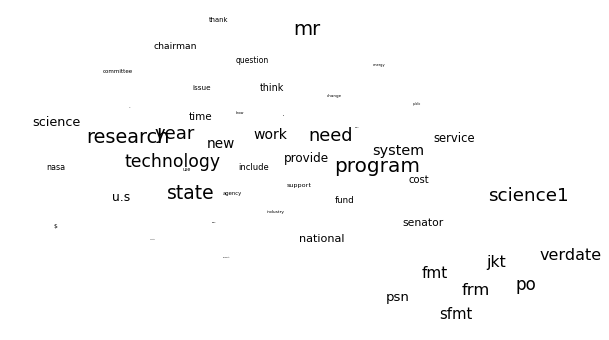

In [ ]:
# viusalization

numWords = 50
targetWords = W2V_CB.wv.index2word[:numWords]

wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(W2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

# Doc2Vec

## <font color="red">*Exercise 2*</font>

<font color="red">Construct cells immediately below this that embed documents related to your final project using `doc2vec`, and explore the relationship between different documents and the word vectors you analyzed in the last exercise. Consider the most similar words to critical documents, analogies (doc _x_ + word _y_), and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the documentary organization of your semantic space?

In [ ]:
import sys
import csv
maxInt = sys.maxsize

while True:
    # decrease the maxInt value by factor 10 
    # as long as the OverflowError occurs.

    try:
        csv.field_size_limit(maxInt)
        break
    except OverflowError:
        maxInt = int(maxInt/10)

In [ ]:
# read pre-processed csv file
DF0510 = pd.read_csv('DF0510.csv', engine='python', index_col = 0)
DF0510[:10]

,index,title,normalized_sents
0,CHRG-110shrg41101,Oversight of the Investigation of the Nasa Ins...,"[['s.', 'hrg'], ['110–434'], ['serial', '110–3..."
1,CHRG-110shrg34743,Promoting Travel to America: An Examination of...,"[['promote'], ['travel'], ['examination', 'eco..."
2,CHRG-110shrg80088,Oversight of the Corporate Average Fuel Econom...,"[['oversight'], ['corporate', 'average'], ['fu..."
3,CHRG-110hhrg35999,A Path Toward the Broader Use of Biofuels: Enh...,"[['path'], ['broad'], ['use', 'biofuel'], ['en..."
4,CHRG-110shrg39014,Transportation Worker Identification Credentia...,"[['transportation', 'worker'], ['identificatio..."
5,CHRG-110hhrg33611,The Department of Homeland Security's R&d Budg...,"[['department', 'homeland', 'security', 'r&d']..."
6,CHRG-109shrg25474,"Nominations to the Department of Commerce, Tra...","[['s.', 'hrg'], ['109–238'], [], ['transportat..."
7,CHRG-110shrg76328,Impact and Policy Implications of Spyware on C...,"[['impact', 'policy'], ['implication'], ['spyw..."
8,CHRG-111shrg52159,Climate Science: Empowering Our Response to Cl...,"[['climate', 'science'], ['empower'], [], ['re..."
9,CHRG-110shrg75785,Oversight of the U.S. Department of Commerce,"[['oversight'], ['u.s', 'department', 'commerc..."


In [ ]:
def unpack_sents(sents):
  word_lst = []
  for sent in sents:
    word_lst.append(sent)

  return word_lst

In [ ]:
DF0510['normalized_words'] = DF0510['normalized_sents'].apply(lambda x: unpack_sents(x))

In [ ]:
DF0510['normalized_words'] 
# does not seem to work; so I reload the raw texts and re-do pre-processing

0      [[, [, ', s, ., ', ,,  , ', h, r, g, ', ], ,, ...
1      [[, [, ', p, r, o, m, o, t, e, ', ], ,,  , [, ...
2      [[, [, ', o, v, e, r, s, i, g, h, t, ', ], ,, ...
3      [[, [, ', p, a, t, h, ', ], ,,  , [, ', b, r, ...
4      [[, [, ', t, r, a, n, s, p, o, r, t, a, t, i, ...
                             ...                        
263    [[, [, ', r, e, a, u, t, h, o, r, i, z, a, t, ...
264    [[, [, ', s, ., ', ,,  , ', h, r, g, ', ], ,, ...
265    [[, [, ', a, m, e, n, d, ', ], ,,  , [, ', e, ...
266    [[, [, ', h, u, m, a, n, ', ,,  , ', s, p, a, ...
267    [[, [, ', o, v, e, r, s, i, g, h, t, ', ,,  , ...
Name: normalized_words, Length: 268, dtype: object

In [ ]:
DF0510

,index,title,raw_text,tokenized_text,normalized_tokens
0,CHRG-110shrg41101,Oversight of the Investigation of the Nasa Ins...,S. HRG. 110–434 \nSERIAL 110–37 \n\nOVERSIGH...,"[S., HRG, 110–434, SERIAL, 110–37, OVERSIGHT, ...","[s., hrg, 110–434, serial, 110–37, oversight, ..."
1,CHRG-110shrg34743,Promoting Travel to America: An Examination of...,PROMOTING \n\nTRAVEL \n\nAN\nEXAMINATION OF ...,"[PROMOTING, TRAVEL, AN, EXAMINATION, OF, ECONO...","[promote, travel, examination, economic, secur..."
2,CHRG-110shrg80088,Oversight of the Corporate Average Fuel Econom...,OVERSIGHT OF THE CORPORATE AVERAGE FUEL \...,"[OVERSIGHT, OF, THE, CORPORATE, AVERAGE, FUEL,...","[oversight, corporate, average, fuel, economy,..."
3,CHRG-110hhrg35999,A Path Toward the Broader Use of Biofuels: Enh...,A PATH TOWARD THE BROADER USE OF\n\nBIOF...,"[A, PATH, TOWARD, THE, BROADER, USE, OF, BIOFU...","[path, broad, use, biofuel, enhance, federal, ..."
4,CHRG-110shrg39014,Transportation Worker Identification Credentia...,TRANSPORTATION WORKER IDENTIFICATION \n\nCRE...,"[TRANSPORTATION, WORKER, IDENTIFICATION, CREDE...","[transportation, worker, identification, crede..."
...,...,...,...,...,...
263,CHRG-109shrg63243,Reauthorization of the Coastal Zone Management...,REAUTHORIZATION OF THE \n\nCOASTAL ZONE MA...,"[REAUTHORIZATION, OF, THE, COASTAL, ZONE, MANA...","[reauthorization, coastal, zone, management, a..."
264,CHRG-109shrg26532,"Nominations of David A. Sampson, to Be Deputy ...",S. HRG. 109–336\n\nNOMINATIONS OF DAVID A...,"[S., HRG, 109–336, NOMINATIONS, OF, DAVID, A.,...","[s., hrg, 109–336, nomination, david, a., samp..."
265,CHRG-110hhrg33105,Amending Executive Order 12866: Good Governanc...,AMENDING EXECUTIVE ORDER 12866:\nGOOD GOVE...,"[AMENDING, EXECUTIVE, ORDER, 12866, GOOD, GOVE...","[amend, executive, order, good, governance, re..."
266,CHRG-109shrg25323,Human Spaceflight: the Space Shuttle and Beyond,HUMAN SPACEFLIGHT: THE SPACE SHUTTLE AND ...,"[HUMAN, SPACEFLIGHT, THE, SPACE, SHUTTLE, AND,...","[human, spaceflight, space, shuttle, s., hrg, ..."


In [ ]:
keywords = ['nuclear', 'nanotechnology', 'broadband', 'hurricane', 'student', 'wireless',
            'airline', 'ocean', 'carbon', 'fishery']

In [ ]:
taggedDocs = []
for index, row in DF0510.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_tokens']]
    docKeywords.append(row['title'])
    docKeywords.append(row['index']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_tokens'], tags = docKeywords))
DF0510['tagged_docs'] = taggedDocs

In [ ]:
D2V = gensim.models.doc2vec.Doc2Vec(DF0510['tagged_docs'], size = 100) #Limiting to 100 dimensions

/usr/local/lib/python3.7/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [ ]:
# represent a doc as a matrix
D2V.docvecs['CHRG-110shrg41101']

array([ 0.09815127, -0.41742522,  0.53369176, -1.0255127 , -0.30471942,
       -0.3423444 , -0.43614256,  0.7706978 , -0.08960193,  0.71622264,
       -1.9692911 , -0.24692424, -0.51685995,  2.2986531 ,  0.86498165,
       -1.3145183 ,  1.9677304 , -0.34135726,  0.9141282 , -1.3886772 ,
       -0.6383119 , -0.02362312,  1.9430544 ,  0.09159048,  0.68604743,
        0.29390463, -0.45795906,  1.119585  ,  0.43979296, -0.8143038 ,
        1.183098  , -1.2169821 ,  0.2265163 ,  2.2768965 , -0.406942  ,
       -1.1363376 , -0.96362346, -2.1954677 ,  1.3716797 , -0.2662804 ,
       -1.1592941 ,  0.36193338,  0.15081564,  0.54080844, -0.25173828,
       -0.3237089 ,  0.41940612,  2.4925396 ,  0.79511917,  0.63288045,
        0.7851319 , -1.1988202 ,  1.6100627 , -0.7509146 , -0.797674  ,
        2.8175497 , -0.5768557 ,  0.6795854 , -0.94021076, -2.4180546 ,
        0.9157007 , -0.32224476, -0.6558866 , -0.33533517,  1.0852228 ,
        0.53977185, -0.6029044 ,  0.45466664, -0.9136161 ,  2.62

In [ ]:
# represent a word as a matrix
D2V['nuclear']

array([ 3.1722867 ,  1.0571151 , -0.20618266,  2.1164212 ,  0.1103556 ,
        1.9202446 ,  1.6532732 , -2.4485397 , -0.18757296,  0.6442079 ,
        2.677314  , -0.6180951 , -1.1435183 ,  1.6572596 ,  0.49546   ,
       -1.0423734 ,  1.5349443 , -0.98043174,  3.4281733 , -0.38500795,
       -1.4478577 ,  0.47450033,  0.50220865, -0.87264955, -1.3720503 ,
       -0.64799273, -1.6596556 ,  0.73341954,  2.7290776 , -3.4383283 ,
        1.0532581 , -1.8879759 ,  0.64370877,  1.1824214 , -1.7140914 ,
        0.40523183, -0.5701957 ,  2.463416  ,  0.41200784,  0.26275095,
        0.13458659, -0.53944576, -2.6787434 ,  2.0114048 ,  1.1126772 ,
        1.5732347 ,  0.18347439,  1.6635467 ,  1.597104  ,  0.47594362,
        1.4411118 , -3.6309648 ,  1.0803882 ,  0.10763971,  1.3460909 ,
       -0.4872385 , -2.5939415 ,  1.2504897 , -0.18142664, -1.071366  ,
        0.41405717, -0.36452687, -1.6631011 , -0.7840879 ,  1.2204162 ,
        1.0428938 ,  2.8599508 ,  0.8975374 , -2.1093976 ,  0.35

In [ ]:
# like W2V, compare distance between words
D2V.most_similar(positive = ['climate', 'internet'], negative = ['carbon'], topn = 10)

[('voice', 0.6614248752593994),
 ('connection', 0.6104219555854797),
 ('misunderstand', 0.58878493309021),
 ('personal', 0.5658654570579529),
 ('computer', 0.5590445399284363),
 ('instant', 0.558264970779419),
 ('brochure', 0.5407975912094116),
 ('conspicuous', 0.5363364219665527),
 ('interchange', 0.534731388092041),
 ('medium', 0.5250805616378784)]

In [ ]:
sklearn.metrics.pairwise.cosine_similarity(D2V['carbon'].reshape(1,-1), D2V['climate'].reshape(1,-1))

array([[0.26956552]], dtype=float32)

In [ ]:
sklearn.metrics.pairwise.cosine_similarity(D2V['internet'].reshape(1,-1), D2V['cable'].reshape(1,-1))

array([[0.56690466]], dtype=float32)

In [ ]:
sklearn.metrics.pairwise.cosine_similarity(D2V['china'].reshape(1,-1), D2V['u.s'].reshape(1,-1))

array([[0.45009986]], dtype=float32)

In [ ]:
# investigate what docs closest to the word 'china'
# why both titles and index appear?
D2V.docvecs.most_similar([D2V['china'] ], topn=5 )

[('The Importation of Canadian Beef That Comes from Animals Older Than 30 Months of Age',
  0.6429018974304199),
 ('CHRG-110shrg35813', 0.6428450345993042),
 ('CHRG-110shrg78188', 0.629159688949585),
 ('Imbalance in U.S.-Korea Automobile Trade', 0.6288338899612427),
 ('CHRG-110shrg35685', 0.6164408922195435)]

In [ ]:
# try to print out the titles of those docs
china_doc = D2V.docvecs.most_similar([D2V['china'] ], topn=5)
docs = []
for doc in china_doc:
  name, score = doc
  if name[:4] == 'CHRG':
    row = DF0510[DF0510['index'] == name]
    title = row['title']
    docs.append(title)
  else:
    docs.append(name)

In [ ]:
docs

['The Importation of Canadian Beef That Comes from Animals Older Than 30 Months of Age',
 107    The Importation of Canadian Beef That Comes fr...
 Name: title, dtype: object,
 83    Imbalance in U.S.-Korea Automobile Trade
 Name: title, dtype: object,
 'Imbalance in U.S.-Korea Automobile Trade',
 62    Overseas Sweatshop Abuses, Their Impact on U.s...
 Name: title, dtype: object]

In [ ]:
# which docs are closer to risk?
D2V.docvecs.most_similar([D2V['risk'] ], topn=5 )

[('CHRG-110hhrg43351', 0.4115368723869324),
 ('The Low-Level Plutonium Spill at Nist-Boulder: Contamination of Lab and Personnel',
  0.41139426827430725),
 ("Cost Management Issues in NASA's Acquisitions and Programs",
  0.3619903028011322),
 ('CHRG-111hhrg47554', 0.361959844827652),
 ('CHRG-110hhrg35235', 0.3542455732822418)]

In [ ]:
risk_doc = D2V.docvecs.most_similar([D2V['risk'] ], topn=5 )
docs = []
for doc in risk_doc:
  name, score = doc
  if name[:4] == 'CHRG':
    row = DF0510[DF0510['index'] == name]
    title = row['title']
    docs.append(title)
  else:
    docs.append(name)

In [ ]:
docs

[161    The Low-Level Plutonium Spill at Nist-Boulder:...
 Name: title, dtype: object,
 'The Low-Level Plutonium Spill at Nist-Boulder: Contamination of Lab and Personnel',
 "Cost Management Issues in NASA's Acquisitions and Programs",
 49    Cost Management Issues in NASA's Acquisitions ...
 Name: title, dtype: object,
 209    Building and Maintaining A Healthy and Strong ...
 Name: title, dtype: object]

In [ ]:
# what words are closer to hearing "Imbalance in U.S.-Korea Automobile Trade"?
D2V.most_similar( [D2V.docvecs['CHRG-110shrg35813'] ], topn=5) 

[('cattle', 0.8236516118049622),
 ('bse', 0.7715116739273071),
 ('canada', 0.7281527519226074),
 ('antifreeze', 0.7277476787567139),
 ('otm', 0.720319390296936)]

In [ ]:
# plot words and docs
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = D2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, D2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

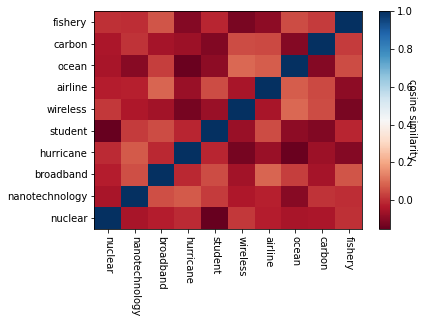

In [ ]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='RdBu')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

In [ ]:
targetDocs = DF0510['index'][:10]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = D2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, D2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

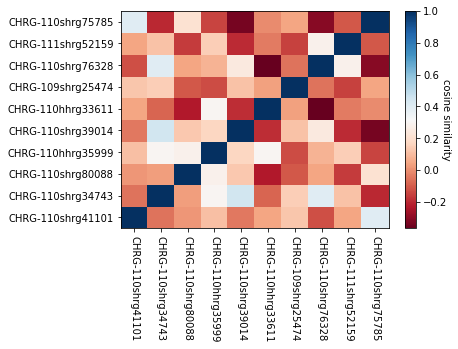

In [ ]:
# documents are barely similar to each other
# suggest that perhaps a sampling strategy according to policy-issue cluster
# makes sense before applying D2V
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='RdBu')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

In [ ]:
# similarities between the first ten documents and our keywords:
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = D2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, D2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

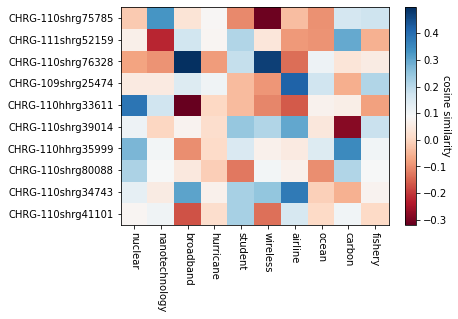

In [ ]:
# this method could be used to test whether different hearing panels
# e.g. directed by Republicans vs. Democrats, who serve as experts, 
# different policy issue focus makes discussions more positive vs. negative,
# nationalist vs. globalist

fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='RdBu')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

In [ ]:
D2V.save('D2V')

# Projection

In [ ]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Sportsdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Sportsdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Sportsdf, 'class')
plt.show()

## <font color="red">*Exercise 3*</font>

<font color="red">Construct cells immediately below this that embed documents related to your final project, then generate meaningful semantic dimensions based on your theoretical understanding of the semantic space (i.e., by subtracting semantically opposite word vectors) and project another set of word vectors onto those dimensions. Interpret the meaning of these projections for your analysis. Which of the dimensions you analyze explain the most variation in the projection of your words and why? 

<font color="red">***Stretch***: Average together multiple antonym pairs to create robust semantic dimensions. How do word projections on these robust dimensions differ from single-pair dimensions?

In [ ]:
#words to create dimensions
tnytTargetWords = ['man','woman', 'expensive',
                   'cheap', 'private', 'public', 'industry', 'national',
                   'american', 'chinese', 'korea', 'japan', 'mexico', 'canada', 'europe']
#words we will be mapping
tnytTargetWords += ["nuclear","nanotechnology", 'drug', 'phd', 'engineer', 'rail',
                    'cable', 'broadcast', 'radio', 'television', 'coal', 'student',
                    'exploration', 'innovation', 'science', 'progress', 'risk', 'uncertainty',
                    'development', 'research']


wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(W2V_CB[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-0.48296207, -0.77132523, -0.7584645 , ...,  0.30113345,
        -1.2961214 ,  0.05494889],
       [-0.39464566, -1.043827  , -2.4679034 , ...,  0.07721343,
        -2.2926116 , -0.82903993],
       [-1.0391825 ,  1.1072266 ,  0.24962696, ...,  0.5794517 ,
         0.53178513, -0.49823684],
       ...,
       [-0.36105633, -0.54900646, -0.3704137 , ...,  2.195476  ,
        -2.07441   ,  0.58961767],
       [-0.26003775,  0.06194274, -0.2024391 , ...,  1.1527458 ,
         1.6399826 ,  1.6209477 ],
       [ 1.1717588 ,  1.1022869 ,  2.0300467 , ...,  3.5056703 ,
        -1.3801167 ,  0.45846054]], dtype=float32)

In [ ]:
pcaWordsNYT = sklearn.decomposition.PCA(n_components = 30).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)
tsneWordsNYT = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataNYT)

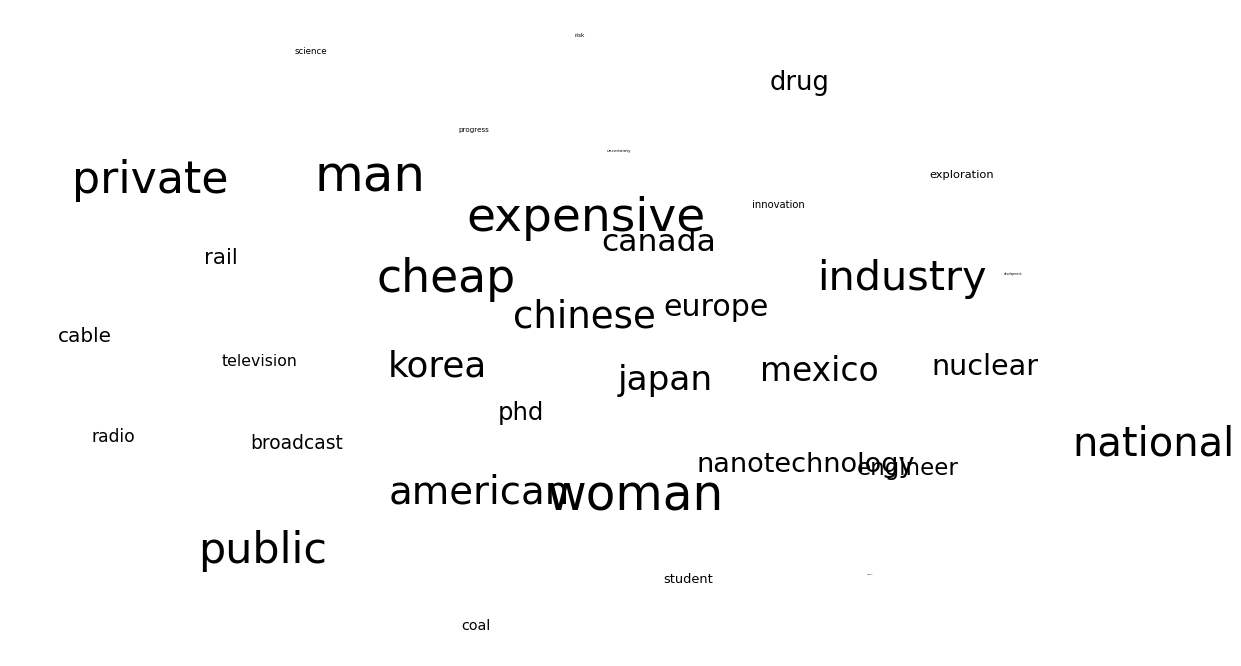

In [ ]:
fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsNYT[:, 0], tsneWordsNYT[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWordsNYT[:, 0][i],tsneWordsNYT[:, 1][i]), size =  50 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

In [ ]:
# Gender = dimension(W2V_CB, ['man'], ['woman'])
Nationality = dimension(W2V_CB, ['america'], ['chinese'])
Class = dimension(W2V_CB, ['cheap'], ['expensive'])
Jurisdiction =  dimension(W2V_CB, ['private', 'industry'],['public', 'national'])

In [ ]:
Education = ['phd', 'engineer', 
                    'student']
Tech = ["nuclear","nanotechnology", 'drug', 'rail','cable', 'broadcast', 'radio', 
        'television', 'coal']
Risk = ['risk', 'uncertainty']
RD = ['exploration', 'innovation', 'science', 'progress', 
                    'development', 'research']

In [ ]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    d = []
    for word in word_list:
        # g.append(sklearn.metrics.pairwise.cosine_similarity(W2V_CB[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(W2V_CB[word].reshape(1,-1), Nationality.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(W2V_CB[word].reshape(1,-1), Class.reshape(1,-1))[0][0])
        d.append(sklearn.metrics.pairwise.cosine_similarity(W2V_CB[word].reshape(1,-1), Jurisdiction.reshape(1,-1))[0][0])
    df = pd.DataFrame({'nationality': r, 'class': c, 'jurisdiction': d}, index = word_list)
    return df

In [ ]:
Edudf = makeDF(W2V_CB, Education) 
Techdf = makeDF(W2V_CB, Tech)
Riskdf = makeDF(W2V_CB, Risk)
RDdf = makeDF(W2V_CB, RD)

In [ ]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

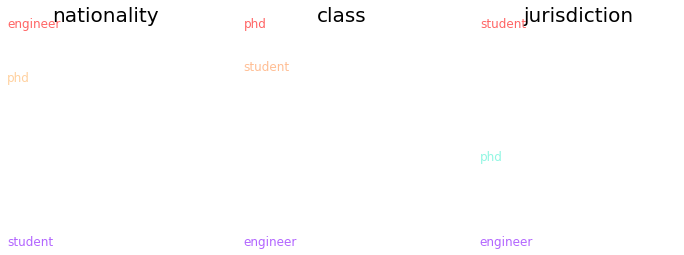

In [ ]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Edudf, 'nationality')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Edudf, 'class')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Edudf, 'jurisdiction')
plt.show()
# phd, student are cheap, engineer is expensive

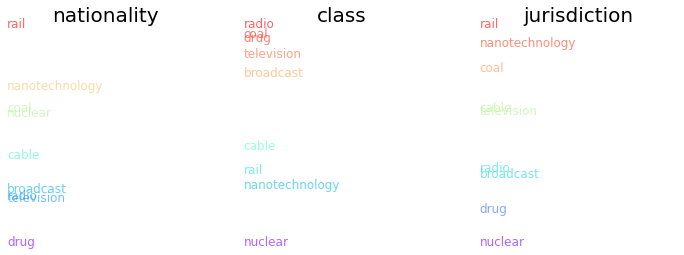

In [ ]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Techdf, 'nationality')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Techdf, 'class')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Techdf, 'jurisdiction')
plt.show()
# radio, coal, television are cheap, nuclear, nanotechnology are expensive
# nuclear, drug are public, rail, nanotechnology are private

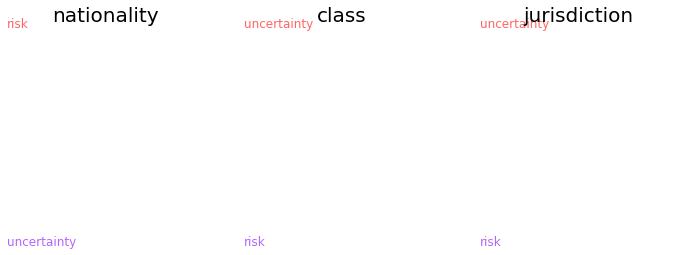

In [ ]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Riskdf, 'nationality')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Riskdf, 'class')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Riskdf, 'jurisdiction')
plt.show() 
# uncertainty is private, cheap, more Chinese; risk is public, expensive, more American

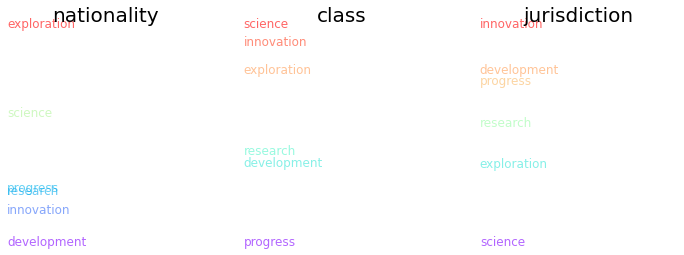

In [ ]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, RDdf, 'nationality')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, RDdf, 'class')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, RDdf, 'jurisdiction')
plt.show() 

# Linguistic Change or Difference

Below is code that aligns the dimensions of multiple embeddings arrayed over time or some other dimension and allow identification of semantic chanage as the word vectors change their loadings for focal words. This code comes from the approach piloted at Stanford by William Hamilton, Daniel Jurafsky and Jure Lescovec [here](https://arxiv.org/pdf/1605.09096.pdf). 

## <font color="red">*Exercise 4b*</font>

<font color="red">**Do only 4a or 4b.** Construct cells immediately below this that align word embeddings over time or across domains/corpora. Interrogate the spaces that result and ask which words changed most and least over the entire period or between contexts/corpora. What does this reveal about the social game underlying your space? 

Overall, this exploration informs me that hearings about climate changes gradually from 109th Congress to 110th Congress, but more rapidly from 110th Congress to 111th Congress. Substantive words such as 'shell', 'climate' changes quite a lot; 'u.s' and 'china' changes slowly, suggesting that their semantic construction is quite stable; adjectives like 'theoretical' barely changes at all. 

In [1]:
import copy

In [2]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = calc_syn0norm(in_base_embed)
    other_vecs = calc_syn0norm(in_other_embed)

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.syn0norm = other_embed.wv.syn0 = (calc_syn0norm(other_embed)).dot(ortho)
    return other_embed
    
def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = calc_syn0norm(m)
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.syn0norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1,m2)

In [16]:
DF0510['tokenized_sents'] = DF0510['raw_text'].apply(lambda x: [lucem_illud.word_tokenize(s, MAX_LEN=1800000) for s in lucem_illud.sent_tokenize(x)])

In [19]:
DF0510['normalized_sents'] = DF0510['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, MAX_LEN=1800000) for s in x])

In [20]:
# group hearings by their congressional session number
y_lst = []
for index, row in DF0510.iterrows():
  year = row['index'][5:8]
  y_lst.append(year)
DF0510['year'] = y_lst

In [21]:
DF0510['year']

0      110
1      110
2      110
3      110
4      110
      ... 
263    109
264    109
265    110
266    109
267    110
Name: year, Length: 268, dtype: object

In [22]:
DF0510 = DF0510.sort_values(by='year')

We will be creating many embeddings so we have created this function to do most of the work. It creates two collections of embeddings, one the original and one the aligned.

In [23]:
def compareModels(df, category, text_column_name='normalized_sents', sort = True, embeddings_raw={}):
    """If you are using time as your category sorting is important"""
    if len(embeddings_raw) == 0:
        embeddings_raw = rawModels(df, category, text_column_name, sort)
    cats = sorted(set(df[category]))
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned

In [24]:
def rawModels(df, category, text_column_name='normalized_sents', sort = True):
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF[text_column_name].sum())
    return embeddings_raw

In [25]:
rawEmbeddings, comparedEmbeddings = compareModels(DF0510, 'year')

In [26]:
rawEmbeddings.keys()

dict_keys(['109', '110', '111'])

We need to compare them across all permutions so we will define another function to help, we will be using 1 - cosine similarity as that gives a more intitive range of 0-2 with low values meaning little change and high meaning lots of change.

In [27]:
def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    print(word)
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cat][0][word], axis = 0),
                                                                             np.expand_dims(embed[word], axis = 0))[0,0]))
    return pd.DataFrame(dists, index = cats)

Lets look at a couple words:

china


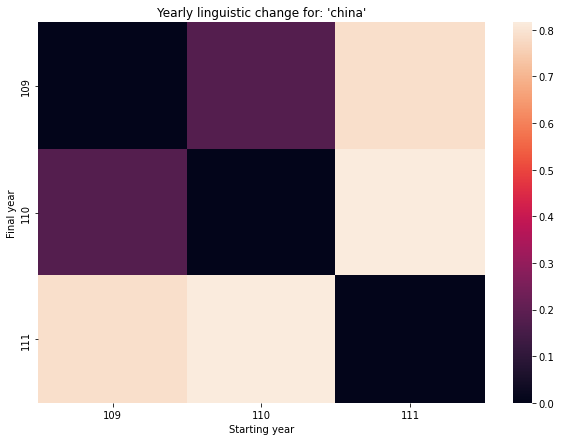

In [29]:
targetWord = 'china'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()
# seems like construction of 'china' changes a lot from 110th to 111th congress

u.s


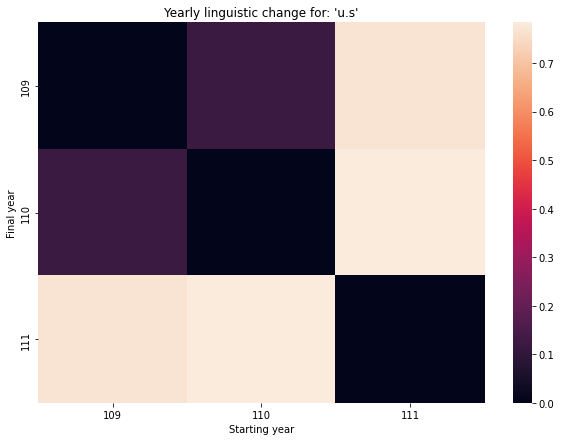

In [32]:
targetWord = 'u.s'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()
# accordingly, the construction of 'u.s'

climate


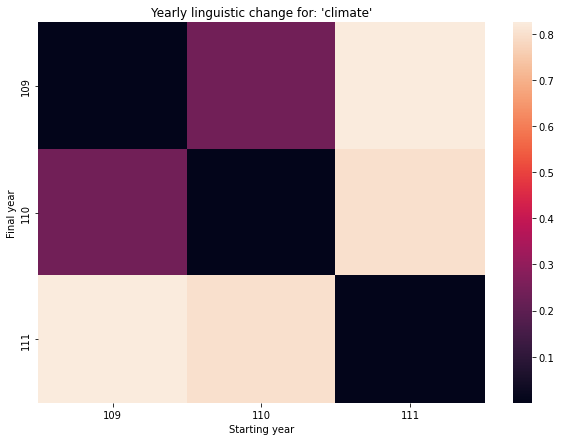

In [33]:
targetWord = 'climate'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()
# climate changes slighting from 109th to 110th, a lot from 110th to 111th

shell


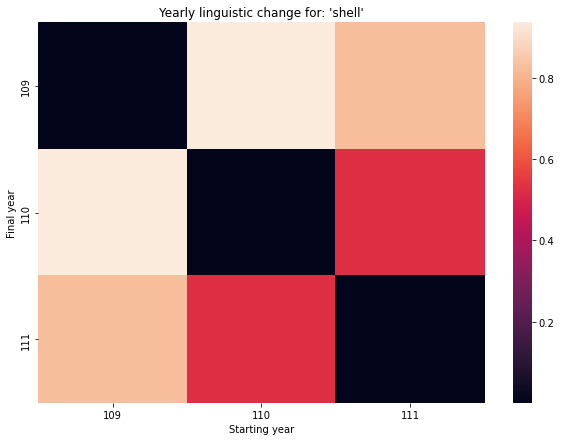

In [40]:
targetWord = 'shell'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

# shell is one of the words that changes the most

In [37]:
def findDiverence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))
    
    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cats[0]][0][word], axis = 0), np.expand_dims(embed[word], axis = 0))[0,0])
    return sum(dists)

def findMostDivergent(embeddingsDict):
    words = []
    for embeds in embeddingsDict.values():
        for embed in embeds:
            words += list(embed.wv.vocab.keys())
    words = set(words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDiverence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)
    

In [38]:
wordDivergences = findMostDivergent(comparedEmbeddings)

Found 6315 words to compare


The most divergent words are:

In [46]:
wordDivergences[:20]

[('a8', 2.122320517897606),
 ('a1b', 2.0810674596577883),
 ('green', 1.977477477863431),
 ('phe-', 1.967592030763626),
 ('a13', 1.9313245564699173),
 ('q12', 1.91801933106035),
 ('shell', 1.761667512357235),
 ('cc', 1.6724665984511375),
 ('a2b', 1.64243383705616),
 ('a12', 1.6338036879897118),
 ('q4a', 1.591497726738453),
 ('fax', 1.5873438268899918),
 ('q2b', 1.544810138642788),
 ('q1a', 1.4880220592021942),
 ('chairmanship', 1.446881264448166),
 ('vacancy', 1.4143948429264128),
 ('magnuson', 1.409132655709982),
 ('delta', 1.4029036164283752),
 ('after-', 1.3947856537997723),
 ('con-', 1.3945426642894745)]

And the least:

In [41]:
wordDivergences[-20:]

[('angry', 0.2491198182106018),
 ('laughter', 0.24802333116531372),
 ('conversely', 0.24607014656066895),
 ('q7', 0.2439078688621521),
 ('ically', 0.24344682693481445),
 ('mario', 0.2427583932876587),
 ('sequentially', 0.2422923445701599),
 ('theoretically', 0.24190211296081543),
 ('newman', 0.2413114309310913),
 ('lb', 0.24016791582107544),
 ('racy', 0.2295016050338745),
 ('detectable', 0.22689902782440186),
 ('shadow', 0.22631216049194336),
 ('pencil', 0.21963578462600708),
 ('versed', 0.21328645944595337),
 ('bama', 0.21115589141845703),
 ('pamela', 0.20640915632247925),
 ('chicken', 0.1994609832763672),
 ('r.e', 0.19543510675430298),
 ('para-', 0.18160796165466309)]

detectable


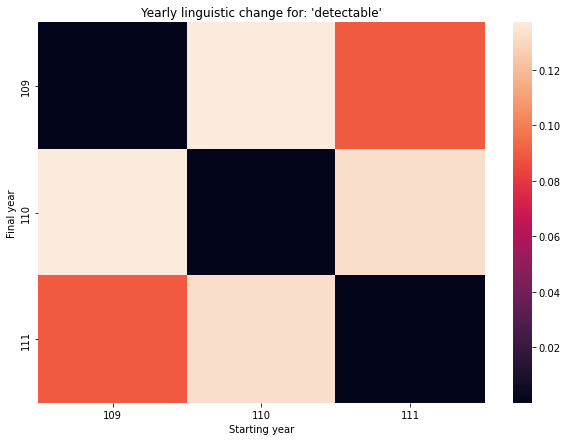

In [48]:
targetWord = 'detectable'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

chairmanship


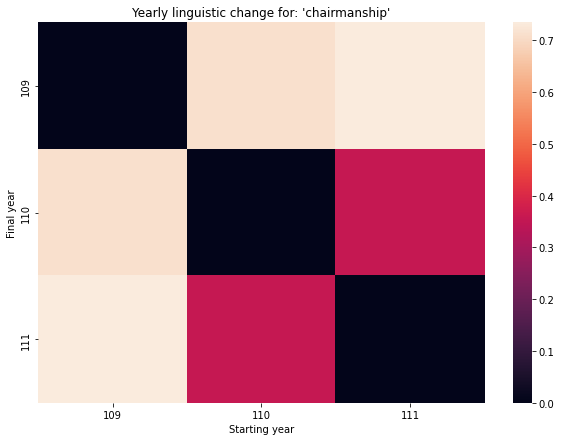

In [49]:
targetWord = 'chairmanship'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()